In [1]:
import os
import math
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor
import graphviz

In [13]:
#DEFINITIONS
def rmse(predicted, actual):
    return np.sqrt(((predicted - actual)**2).mean())
PROJECT_FOLDER = r"C:\Users\bryan.zanoli\OneDrive\Documents\School\CSUMB\CST383-30\project"

###Data Preparation

In [15]:
##READ IN WEATHER STATION DATA FROM ALL CSVs
folder_path = PROJECT_FOLDER + '\\station_data'

df_weatherdata = pd.DataFrame()

for filename in os.listdir(folder_path):
    if os.path.isfile(os.path.join(folder_path, filename)):
        df_station = pd.read_csv(folder_path + '\\' + filename, nrows = 1, header = 0)
        df_weather = pd.read_csv(folder_path + '\\' + filename, skiprows = 3)
        #print('Station: ',df_station.head(3))
        #print('Weather: ',df_weather.head(3))
        df_weather['key'] = 1
        df_station['key'] = 1
        df_new = pd.merge(df_station, df_weather, on='key').drop('key', axis = 1)
        #print('New: ',df_new.head(3))
        df_weatherdata = pd.concat([df_new, df_weatherdata], axis = 0)

df_weatherdata['year'] = pd.to_datetime(df_weatherdata['time']).dt.year

print('Weather Data Read In: ',df_weatherdata.head(10))
df_weatherdata.info()

##CREATE coordinates DataFrame from df_weatherdata
df_location = df_weatherdata[['latitude', 'longitude']].drop_duplicates()
print('Location Data Read In: \n',df_location)

Weather Data Read In:      latitude  longitude  elevation  utc_offset_seconds             timezone  \
0  41.933216 -120.74127     1605.0              -28800  America/Los_Angeles   
1  41.933216 -120.74127     1605.0              -28800  America/Los_Angeles   
2  41.933216 -120.74127     1605.0              -28800  America/Los_Angeles   
3  41.933216 -120.74127     1605.0              -28800  America/Los_Angeles   
4  41.933216 -120.74127     1605.0              -28800  America/Los_Angeles   
5  41.933216 -120.74127     1605.0              -28800  America/Los_Angeles   
6  41.933216 -120.74127     1605.0              -28800  America/Los_Angeles   
7  41.933216 -120.74127     1605.0              -28800  America/Los_Angeles   
8  41.933216 -120.74127     1605.0              -28800  America/Los_Angeles   
9  41.933216 -120.74127     1605.0              -28800  America/Los_Angeles   

  timezone_abbreviation        time  temperature_2m_max (°F)  \
0                 GMT-8  2014-01-01        

In [17]:
##CREATE coordinates DataFrame from df_weatherdata
df_location = df_weatherdata[['latitude', 'longitude']].drop_duplicates()
print('Location Data Read In: \n',df_location)

Location Data Read In: 
     latitude   longitude
0  41.933216 -120.741270
0  41.722317 -120.347336
0  41.581722 -121.688310
0  41.441124 -121.338150
0  41.441124 -120.302170
0  41.370823 -122.198290
0  41.230230 -122.492840
0  41.230230 -120.687680
0  41.159927 -121.802580
0  41.159927 -120.257520
0  41.019330 -120.171190
0  40.738136 -121.021270
0  40.667835 -120.977340
0  40.527240 -121.144060
0  40.456940 -121.100130
0  40.456940 -120.211560
0  40.246044 -121.980330
0  40.246044 -120.842700
0  40.246044 -120.589890
0  40.175747 -122.819060
0  40.175747 -121.935470
0  40.175747 -121.683014
0  40.105446 -120.378140
0  40.035150 -120.713270
0  39.964848 -122.932950
0  39.964848 -120.544680
0  39.964848 -120.167590
0  39.894550 -120.627610
0  39.824253 -120.710300
0  39.753952 -122.920730
0  39.753952 -121.043120
0  39.736538 -122.870285


In [23]:
##READ IN TEST DATA - Weather Station Data not reflected in rain stations
folder_path = PROJECT_FOLDER + '\\test_data_with_prec'

df_testdata = pd.DataFrame()

for filename in os.listdir(folder_path):
    if os.path.isfile(os.path.join(folder_path, filename)):
        df_station = pd.read_csv(folder_path + "\\" + filename, nrows = 1, header = 0)
        df_weather = pd.read_csv(folder_path + "\\" + filename, skiprows = 3)
        #print('Station: ',df_station.head(3))
        #print('Weather: ',df_weather.head(3))
        df_weather['key'] = 1
        df_station['key'] = 1
        df_new = pd.merge(df_station, df_weather, on='key').drop('key', axis = 1)
        #print('New: ',df_new.head(3))
        df_testdata = pd.concat([df_new, df_testdata], axis = 0)

df_testdata['year'] = pd.to_datetime(df_testdata['time']).dt.year
df_testdata['location'] = df_testdata['latitude'].astype('str')+' '+df_testdata['longitude'].astype('str')

print('Test Data Read In: ',df_testdata.head(10))
df_testdata.info()

df_testdata['temp_max_mean'] = df_testdata.groupby(['location', 'year'])['temperature_2m_max (°F)'].transform("mean")
df_testdata['temp_min_mean'] = df_testdata.groupby(['location', 'year'])['temperature_2m_min (°F)'].transform("mean")
df_testdata['temp_min_ann'] = df_testdata.groupby(['location', 'year'])['temperature_2m_min (°F)'].transform("min")
df_testdata['temp_max_ann'] = df_testdata.groupby(['location', 'year'])['temperature_2m_max (°F)'].transform("max")
df_testdata['temp_mean_ann'] = df_testdata.groupby(['location', 'year'])['temperature_2m_mean (°F)'].transform("mean")
df_testdata['temp_mean_max'] = df_testdata.groupby(['location', 'year'])['temperature_2m_mean (°F)'].transform("max")
df_testdata['temp_mean_min'] = df_testdata.groupby(['location', 'year'])['temperature_2m_mean (°F)'].transform("min")
df_testdata['wind_speed_max_min'] = df_testdata.groupby(['location', 'year'])['wind_speed_10m_max (mp/h)'].transform("min")
df_testdata['wind_speed_max_max'] = df_testdata.groupby(['location', 'year'])['wind_speed_10m_max (mp/h)'].transform("max")
df_testdata['wind_speed_max_mean'] = df_testdata.groupby(['location', 'year'])['wind_speed_10m_max (mp/h)'].transform("mean")
df_testdata['wind_gusts_max_min'] = df_testdata.groupby(['location', 'year'])['wind_gusts_10m_max (mp/h)'].transform("min")
df_testdata['wind_gusts_max_max'] = df_testdata.groupby(['location', 'year'])['wind_gusts_10m_max (mp/h)'].transform("max")
df_testdata['wind_gusts_max_mean'] = df_testdata.groupby(['location', 'year'])['wind_gusts_10m_max (mp/h)'].transform("mean")
df_testdata['precipitation_hours_sum'] = df_testdata.groupby(['location', 'year'])['precipitation_hours (h)'].transform("sum")
df_testdata['precipitation_hours_mean'] = df_testdata.groupby(['location', 'year'])['precipitation_hours (h)'].transform("mean")
df_testdata['evapotranspiration_min'] = df_testdata.groupby(['location', 'year'])['et0_fao_evapotranspiration (inch)'].transform("min")
df_testdata['evapotranspiration_max'] = df_testdata.groupby(['location', 'year'])['et0_fao_evapotranspiration (inch)'].transform("max")
df_testdata['evapotranspiration_mean'] = df_testdata.groupby(['location', 'year'])['et0_fao_evapotranspiration (inch)'].transform("mean")
df_testdata['precipitation_sum'] = df_testdata.groupby(['location', 'year'])['precipitation_sum (inch)'].transform("sum")

df_testdata.drop(['time', 'temperature_2m_max (°F)', 'temperature_2m_min (°F)', 'temperature_2m_mean (°F)',
                          'precipitation_hours (h)', 'wind_speed_10m_max (mp/h)', 'wind_gusts_10m_max (mp/h)',
                          'et0_fao_evapotranspiration (inch)', 'rain_sum (inch)', 'precipitation_sum (inch)'], 
            axis = 1, inplace = True)

print(df_testdata['location'][0:8000:500])

df_testdata = df_testdata.drop_duplicates(subset = ['location', 'year'])
df_testdata = df_testdata.reset_index(drop=True)

df_testdata.info()

print('Test Data Read In: ', df_testdata)

Test Data Read In:      latitude  longitude  elevation  utc_offset_seconds             timezone  \
0  41.722317 -122.56152      791.0              -28800  America/Los_Angeles   
1  41.722317 -122.56152      791.0              -28800  America/Los_Angeles   
2  41.722317 -122.56152      791.0              -28800  America/Los_Angeles   
3  41.722317 -122.56152      791.0              -28800  America/Los_Angeles   
4  41.722317 -122.56152      791.0              -28800  America/Los_Angeles   
5  41.722317 -122.56152      791.0              -28800  America/Los_Angeles   
6  41.722317 -122.56152      791.0              -28800  America/Los_Angeles   
7  41.722317 -122.56152      791.0              -28800  America/Los_Angeles   
8  41.722317 -122.56152      791.0              -28800  America/Los_Angeles   
9  41.722317 -122.56152      791.0              -28800  America/Los_Angeles   

  timezone_abbreviation        time  temperature_2m_max (°F)  \
0                 GMT-8  2014-01-01           

In [21]:
##READ IN RAIN STATION DATA
df_rain = pd.read_csv(PROJECT_FOLDER + '\\lwu-precip-data-to-2023_basic_flatfile_withcoordinates.csv', index_col=None)
df_rain.columns = df_rain.columns.str.strip()
df_rain.info()

df_rain = df_rain.dropna(subset = ['TotalPrecipitation_inches', 'WaterYear'])
nonfloat = np.where(df_rain['TotalPrecipitation_inches'] == '.')[0]
df_rain.drop(df_rain.index[nonfloat], inplace=True)
df_rain.drop(['BeginGageServiceDate', 'EndGageServiceDate', 'Notes_FlaggedResults'], axis = 1, inplace = True)

df_rain['TotalPrecipitation_inches'] = df_rain['TotalPrecipitation_inches'].astype('float64')

df_rain.info()


##Find nearest WEATHER STATION to RAIN STATION
for rain in df_rain.index :
    min_dist = float(1e7)
    selected_long = 0
    selected_lat = 0
    for location in df_location.values:
        # print('Location: ', location)
        # print('X Coord: ', df_rain.loc[rain, ['x_coord']])
        # print('Operation: ', location[1] - df_rain.loc[rain, ['x_coord']])
        distance = (location[1] - df_rain.loc[rain, ['x_coord']].values)**2 + (location[0] - df_rain.loc[rain, ['y_coord']].values)**2
        if(distance < min_dist):
            min_dist = distance
            selected_long = location[1]
            selected_lat = location[0]
        #print(distances)
    df_rain.loc[rain, 'min_distance'] = min_dist
    df_rain.loc[rain, 'longitude'] = selected_long
    df_rain.loc[rain, 'latitude'] = selected_lat

print(df_rain[['StationName', 'x_coord', 'y_coord', 'longitude', 'latitude']])
print(df_weatherdata[['longitude', 'latitude']])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152 entries, 0 to 2151
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   StationName                2152 non-null   object 
 1   County                     2152 non-null   object 
 2   BeginGageServiceDate       1868 non-null   object 
 3   EndGageServiceDate         1874 non-null   object 
 4   TotalPrecipitation_inches  2085 non-null   object 
 5   WaterYear                  2152 non-null   int64  
 6   Notes_FlaggedResults       416 non-null    object 
 7   x_coord                    2152 non-null   float64
 8   y_coord                    2152 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 151.4+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 2083 entries, 0 to 2151
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 

In [25]:
#Merge WEATHER and RAIN STATION data
df_all = pd.merge(df_rain, df_weatherdata, left_on = ['latitude', 'longitude', 'WaterYear'], right_on=['latitude', 'longitude', 'year'], how = 'inner')
print(df_all[['StationName', 'time', 'WaterYear', 'wind_speed_10m_max (mp/h)']])

              StationName        time  WaterYear  wind_speed_10m_max (mp/h)
0           Ball Mountain  2014-01-01       2014                        2.4
1           Ball Mountain  2014-01-02       2014                        2.0
2           Ball Mountain  2014-01-03       2014                        3.5
3           Ball Mountain  2014-01-04       2014                        6.0
4           Ball Mountain  2014-01-05       2014                        5.1
...                   ...         ...        ...                        ...
102624  Three Mile Valley  2023-12-27       2023                        8.5
102625  Three Mile Valley  2023-12-28       2023                        4.4
102626  Three Mile Valley  2023-12-29       2023                       11.2
102627  Three Mile Valley  2023-12-30       2023                        4.5
102628  Three Mile Valley  2023-12-31       2023                        4.5

[102629 rows x 4 columns]


In [27]:
##Create new annual aggs based on monthly variables
df_all['temp_max_mean'] = df_all.groupby(['StationName', 'year'])['temperature_2m_max (°F)'].transform("mean")
df_all['temp_min_mean'] = df_all.groupby(['StationName', 'year'])['temperature_2m_min (°F)'].transform("mean")
df_all['temp_min_ann'] = df_all.groupby(['StationName', 'year'])['temperature_2m_min (°F)'].transform("min")
df_all['temp_max_ann'] = df_all.groupby(['StationName', 'year'])['temperature_2m_max (°F)'].transform("max")
df_all['temp_mean_ann'] = df_all.groupby(['StationName', 'year'])['temperature_2m_mean (°F)'].transform("mean")
df_all['temp_mean_max'] = df_all.groupby(['StationName', 'year'])['temperature_2m_mean (°F)'].transform("max")
df_all['temp_mean_min'] = df_all.groupby(['StationName', 'year'])['temperature_2m_mean (°F)'].transform("min")
df_all['wind_speed_max_min'] = df_all.groupby(['StationName', 'year'])['wind_speed_10m_max (mp/h)'].transform("min")
df_all['wind_speed_max_max'] = df_all.groupby(['StationName', 'year'])['wind_speed_10m_max (mp/h)'].transform("max")
df_all['wind_speed_max_mean'] = df_all.groupby(['StationName', 'year'])['wind_speed_10m_max (mp/h)'].transform("mean")
df_all['wind_gusts_max_min'] = df_all.groupby(['StationName', 'year'])['wind_gusts_10m_max (mp/h)'].transform("min")
df_all['wind_gusts_max_max'] = df_all.groupby(['StationName', 'year'])['wind_gusts_10m_max (mp/h)'].transform("max")
df_all['wind_gusts_max_mean'] = df_all.groupby(['StationName', 'year'])['wind_gusts_10m_max (mp/h)'].transform("mean")
df_all['precipitation_hours_sum'] = df_all.groupby(['StationName', 'year'])['precipitation_hours (h)'].transform("sum")
df_all['precipitation_hours_mean'] = df_all.groupby(['StationName', 'year'])['precipitation_hours (h)'].transform("mean")
df_all['evapotranspiration_min'] = df_all.groupby(['StationName', 'year'])['et0_fao_evapotranspiration (inch)'].transform("min")
df_all['evapotranspiration_max'] = df_all.groupby(['StationName', 'year'])['et0_fao_evapotranspiration (inch)'].transform("max")
df_all['evapotranspiration_mean'] = df_all.groupby(['StationName', 'year'])['et0_fao_evapotranspiration (inch)'].transform("mean")


In [37]:
##Drop all monthly only variables as granularity isn't required
df_all_new = df_all.drop(['time', 'temperature_2m_max (°F)', 'temperature_2m_min (°F)', 'temperature_2m_mean (°F)',
                          'precipitation_hours (h)', 'wind_speed_10m_max (mp/h)', 'wind_gusts_10m_max (mp/h)',
                          'et0_fao_evapotranspiration (inch)'], axis = 1)

##Drop duplicate rows as elimination of monthly variables should allow for large reduction
df_all_new = df_all_new.drop_duplicates(subset = ['StationName', 'year'])
df_all_new = df_all_new.reset_index(drop=True)

##Verify new dataframe
df_all_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   StationName                280 non-null    object 
 1   County                     280 non-null    object 
 2   TotalPrecipitation_inches  280 non-null    float64
 3   WaterYear                  280 non-null    int64  
 4   x_coord                    280 non-null    float64
 5   y_coord                    280 non-null    float64
 6   min_distance               280 non-null    object 
 7   longitude                  280 non-null    float64
 8   latitude                   280 non-null    float64
 9   elevation                  280 non-null    float64
 10  utc_offset_seconds         280 non-null    int64  
 11  timezone                   280 non-null    object 
 12  timezone_abbreviation      280 non-null    object 
 13  year                       280 non-null    int32  

###DEFINE INITIAL TRAINING - LINEAR REGRESSION FOR FEATURE SELECTION
The below runs through analysis using the 2023 data as test data, and the years before as training data. 
The initial predictors include most of the features from the data set, though are broken up by Weather and Geography based features. This will help us answer more specific questions, such as does geography or other non-precipitation based weather conditions help to predict rainfall. 

In [63]:
predictors_weather = ['temp_max_mean', 'temp_min_mean', 'temp_min_ann', 'temp_max_ann', 'temp_mean_ann', 'temp_mean_max', 'temp_mean_min', 'wind_speed_max_min', 
              'wind_speed_max_max', 'wind_speed_max_mean', 'wind_gusts_max_min', 'wind_gusts_max_max', 'wind_gusts_max_mean',
                     'evapotranspiration_min', 'evapotranspiration_max', 'evapotranspiration_mean']
predictors_geography = ['elevation', 'latitude', 'longitude']
target = 'TotalPrecipitation_inches'

predictors_dummies =['elevation',
                    'StationName_Blacks Mountain',
                    'StationName_Boulder Creek',
                    'StationName_Butte Lake',
                    'StationName_Camel Peak',
                    'StationName_Champs Flat',
                    'StationName_Clarks Peak',
                    'StationName_Clover Valley',
                    'StationName_Crowder Flat',
                    'StationName_Dewitt Peak',
                    'StationName_Dodge Reservoir',
                    'StationName_Gazelle Mountain',
                    'StationName_Granite Springs',
                    'StationName_Hogsback Road',
                    'StationName_Lassen Creek',
                    'StationName_Lights Creek',
                    'StationName_Little Last Chance',
                    'StationName_Long Bell Station',
                    'StationName_McCarthy Point',
                    'StationName_Medicine Lake',
                    'StationName_Mount Hough',
                    'StationName_Mount Shasta',
                    'StationName_Mumbo Basin',
                    'StationName_Onion Valley',
                    'StationName_Patterson Meadow',
                    'StationName_Pepperdine Camp',
                    'StationName_Saddle Camp',
                    'StationName_Shaffer Mountain',
                    'StationName_Stouts Meadow',
                    'StationName_Swain Mountain',
                    'StationName_Sweagert Flat']



Let's see if any of the predictors for weather have a meanful impact on precipitation

(29, 16)
(29,)
(251, 16)
(251,)
R2 Score of temp_max_mean: -0.169
R2 Score of temp_min_mean: -0.192
R2 Score of temp_min_ann: -0.262
R2 Score of temp_max_ann: -0.236
R2 Score of temp_mean_ann: -0.171
R2 Score of temp_mean_max: -0.220
R2 Score of temp_mean_min: -0.246
R2 Score of wind_speed_max_min: -0.248
R2 Score of wind_speed_max_max: -0.175
R2 Score of wind_speed_max_mean: -0.209
R2 Score of wind_gusts_max_min: 0.029
R2 Score of wind_gusts_max_max: -0.129
R2 Score of wind_gusts_max_mean: 0.041
R2 Score of evapotranspiration_min: -0.098
R2 Score of evapotranspiration_max: -0.170
R2 Score of evapotranspiration_mean: -0.052


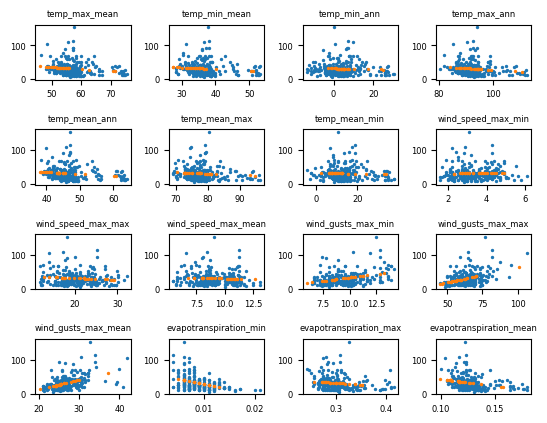

<Figure size 2000x1500 with 0 Axes>

In [76]:
X_train = df_all_new[~(df_all_new['year'] == 2023)][predictors_weather]
y_train = df_all_new[~(df_all_new['year'] == 2023)][target]
X_test = df_all_new[df_all_new['year'] == 2023][predictors_weather]
y_test = df_all_new[df_all_new['year'] == 2023][target]
X = X_train
y = y_train

print(X_test.shape)
print(y_test.shape)
print(X.shape)
print(y.shape)

fig, axes = plt.subplots(nrows = math.ceil(np.sqrt(X.shape[1])), ncols = math.ceil(X.shape[1] / math.ceil(np.sqrt(X.shape[1]))),
                         gridspec_kw={'wspace': .4, 'hspace': .9})
plt.rcParams['axes.titlesize'] = 6
plt.figure(figsize= (20, 15))
plt.tight_layout()

i = 0
cols = math.ceil(X.shape[1] / math.ceil(np.sqrt(X.shape[1])))
for predictor in predictors_weather:
    k = i % cols
    j = math.floor (i / cols)
    X_ = X[[predictor]]
    X_train_ = X_train[[predictor]]
    X_test_ = X_test[[predictor]]
    # X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.25, random_state=42)
    reg = LinearRegression()
    reg.fit(X_train_, y_train)
    predicted = reg.predict(X_test_)
    axes[j][k].scatter(X_train_, y_train, s = 2)
    axes[j][k].scatter(X_test_, predicted, s = 2)
    axes[j][k].set_title(predictor)
    axes[j][k].tick_params(axis='both', labelsize=6)
    i += 1
    print('R2 Score of {}: {:.3f}'.format(predictor, r2_score(y_test, predicted)))

plt.show()

The features all have very poor fit and don't well predict the model. If all features are run simultaneously, the model shows its poor performance. As shown below, even the training data doesn't yield very accurate results, indicating an underfit scenario.

R2 Score of All: 0.352


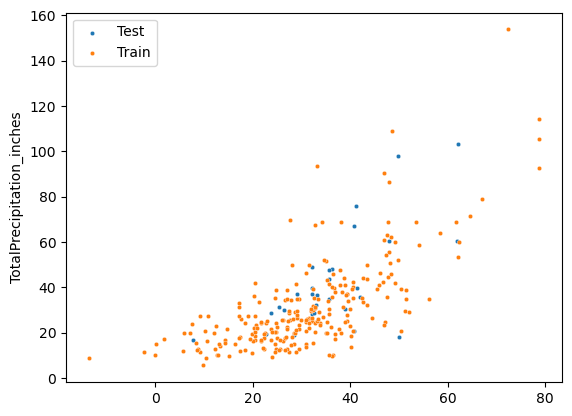

In [78]:
reg.fit(X_train, y_train)
predicted = reg.predict(X_test)
print('R2 Score of All: {:.3f}'.format(r2_score(y_test, predicted)))

sns.scatterplot(x = predicted, y = y_test, s = 10, label = 'Test')
sns.scatterplot(x = reg.predict(X_train), y = y_train, s = 10, label = 'Train')
plt.title('Total Precipitation Prediction by Weather Features')
plt.legend()
plt.show()

(29, 3)
(29,)
(251, 3)
(251,)
R2 Score of elevation: -0.240
R2 Score of latitude: -0.243
R2 Score of longitude: -0.163


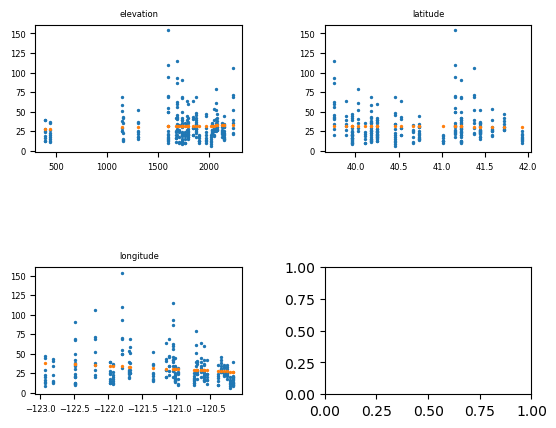

<Figure size 2000x1500 with 0 Axes>

In [69]:
X_train = df_all_new[~(df_all_new['year'] == 2023)][predictors_geography]
y_train = df_all_new[~(df_all_new['year'] == 2023)][target]
X_test = df_all_new[df_all_new['year'] == 2023][predictors_geography]
y_test = df_all_new[df_all_new['year'] == 2023][target]
X = X_train
y = y_train

print(X_test.shape)
print(y_test.shape)
print(X.shape)
print(y.shape)

fig, axes = plt.subplots(nrows = math.ceil(np.sqrt(X.shape[1])), ncols = math.ceil(X.shape[1] / math.ceil(np.sqrt(X.shape[1]))),
                         gridspec_kw={'wspace': .4, 'hspace': .9})
plt.rcParams['axes.titlesize'] = 6
plt.figure(figsize= (20, 15))
plt.tight_layout()

i = 0
cols = math.ceil(X.shape[1] / math.ceil(np.sqrt(X.shape[1])))
for predictor in predictors_geography:
    k = i % cols
    j = math.floor (i / cols)
    X_ = X[[predictor]]
    X_train_ = X_train[[predictor]]
    X_test_ = X_test[[predictor]]
    # X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.25, random_state=42)
    reg = LinearRegression()
    reg.fit(X_train_, y_train)
    predicted = reg.predict(X_test_)
    axes[j][k].scatter(X_train_, y_train, s = 2)
    axes[j][k].scatter(X_test_, predicted, s = 2)
    axes[j][k].set_title(predictor)
    axes[j][k].tick_params(axis='both', labelsize=6)
    i += 1
    print('R2 Score of {}: {:.3f}'.format(predictor, r2_score(y_test, predicted)))

plt.show()

Again, the full feature analysis shows that there is extreme underfitting. 

R2 Score of All: -0.101


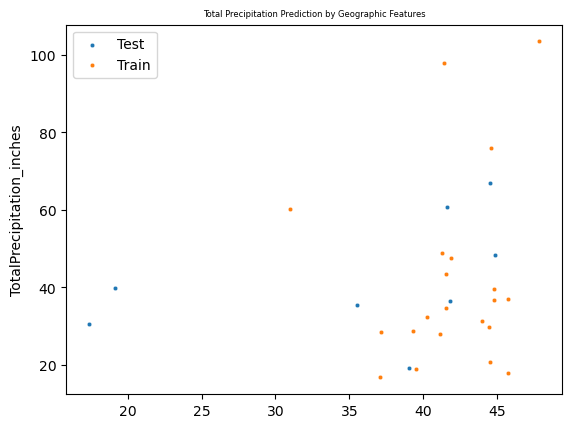

In [134]:
reg.fit(X_train, y_train)
predicted = reg.predict(X_test)
print('R2 Score of All: {:.3f}'.format(r2_score(y_test, predicted)))

sns.scatterplot(x = predicted, y = y_test, s = 10, label = 'Test')
sns.scatterplot(x = reg.predict(X_train), y = y_train, s = 10, label = 'Train')
plt.title('Total Precipitation Prediction by Geographic Features')
plt.legend()
plt.show()

As with the weather predictors, the features for geography are also poor. However, though it's not believed there will be a better outcome with Polynomial Features, let's check this to be sure. 

In [144]:
##Polynomial Features Analysis
X = df_all_new[df_all_new['year'] == 2023][predictors_weather]
y = df_all_new[df_all_new['year'] == 2023][target]
pf = PolynomialFeatures(degree = 3)
pf.fit(X)
X_poly = pf.transform(X)
print(X_poly.shape)

rmse_min = float(1e7)
rmse_i_min = 0
r2_max = float(0)
r2_i_max = 0
rmse_selected = [[None for _ in range(2)] for _ in range(1)]
r2_selected = [[None for _ in range(2)] for _ in range(1)]

for i in range(X_poly.shape[1]):
    X_ = X_poly[:,[i]]
    X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.25, random_state=42)
    
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    predicted = reg.predict(X_test)
    rmse_train = rmse(reg.predict(X_train), y_train)
    rmse_test = rmse(predicted, y_test)
    r2 = r2_score(y_test, predicted)
    if rmse_test < rmse_min:
        rmse_min = rmse_test
        rmse_i_min = i
        print('New RMSE Test Min: {:.3f}'.format(rmse_min))
        for j in range(10):
            if rmse_selected[0][0] == None:
                rmse_selected[0][0] = rmse_min
                rmse_selected[0][1] = rmse_i_min
                break
            if len(rmse_selected) < 10:
                rmse_selected.append([rmse_min, rmse_i_min])
                break
            else:
                rmse_selected[rmse_selected[rmse_selected[:0] == np.max(rmse_selected[:0])].index][0] = rmse_min
                rmse_selected[rmse_selected[rmse_selected[:0] == np.max(rmse_selected[:0])].index][1] = rmse_max
                break
    if r2 > r2_max:
        r2_max = r2
        r2_i_max = i
        print('New R2 Max: {:.3f}'.format(r2_max))
        for j in range(10):
            if r2_selected[0][0] == None:
                r2_selected[0][0] = r2_max
                r2_selected[0][1] = r2_i_max
                break
            if len(r2_selected) < 10:
                r2_selected.append([r2_max, r2_i_max])
                break
            else:
                r2_selected[r2_selected[r2_selected[:0] == np.min(r2_selected[:0])].index][0] = r2_max
                r2_selected[r2_selected[r2_selected[:0] == np.min(r2_selected[:0])].index][0] = r2_i_max

rmse_selected = np.array(rmse_selected)
r2_selected = np.array(r2_selected)

print('RMSE Features: ', pf.get_feature_names_out()[rmse_selected[:,1].astype(int)]) 
print('R2 Features: ', pf.get_feature_names_out()[r2_selected[:,1].astype(int)]) 

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.25, random_state=42)

remaining = list(range(X_train.shape[1]))
i_min = 0
selected = []
n = 1

while len(selected) < n: 
    rmse_min = 1e7
    for i in remaining: 
        current = selected.copy()
        current.append(i)
        X_ = X_train[:, current]
        scores = cross_val_score(LinearRegression(), X_, y_train, scoring = 'neg_mean_squared_error', cv = 5)
        rmse_value = np.sqrt(-scores.mean())
        if (rmse_value < rmse_min):
            rmse_min = rmse_value
            i_min = i
    remaining.remove(i_min)
    selected.append(i_min)
    print('num features: {}; rmse: {:.2f}'.format(len(selected), rmse_min))

for feat_num in selected:
    print('Feature Names: ', pf.get_feature_names_out()[feat_num])  

X_10 = X_poly[:, [r2_i_max]]
X_train, X_test, y_train, y_test = train_test_split(X_10, y, test_size=0.25, random_state=42)
reg2 = LinearRegression()
reg2.fit(X_train, y_train)
print('R2 Max Feature - {} receives R2 Score: {:.3f}'.format(pf.get_feature_names_out()[r2_i_max],r2_score(y_test, reg2.predict(X_test))))

(29, 969)
New RMSE Test Min: 14.699
New RMSE Test Min: 14.448
New R2 Max: 0.033
New RMSE Test Min: 13.956
New R2 Max: 0.098
New RMSE Test Min: 13.806
New R2 Max: 0.117
New RMSE Test Min: 13.652
New R2 Max: 0.137
New RMSE Test Min: 13.512
New R2 Max: 0.155
New RMSE Test Min: 11.640
New R2 Max: 0.373
New RMSE Test Min: 11.306
New R2 Max: 0.408
RMSE Features:  ['1' 'temp_max_mean' 'temp_mean_max' 'wind_speed_max_min'
 'wind_gusts_max_max' 'evapotranspiration_min' 'evapotranspiration_max'
 'wind_speed_max_min evapotranspiration_max^2']
R2 Features:  ['temp_max_mean' 'temp_mean_max' 'wind_speed_max_min' 'wind_gusts_max_max'
 'evapotranspiration_min' 'evapotranspiration_max'
 'wind_speed_max_min evapotranspiration_max^2']
num features: 1; rmse: 15.27
Feature Names:  temp_max_mean wind_gusts_max_mean^2
R2 Max Feature - wind_speed_max_min evapotranspiration_max^2 receives R2 Score: 0.408


The top score of .408 almost looks like this feature will perform well predictively. Let's plot this out.

[0.2209104 0.2310399 0.2310399 0.4185792 0.3371004 0.2083823 0.3509968
 0.4986289 0.4480848 0.5451776 0.2131947 0.2952794 0.4681638 0.2422109
 0.2083823 0.27      0.3825936 0.4732608 0.2550372 0.2327356 0.1769472
 0.2131947 0.3483648 0.322624  0.286443  0.4088484 0.3110217 0.4077045
 0.3173798]


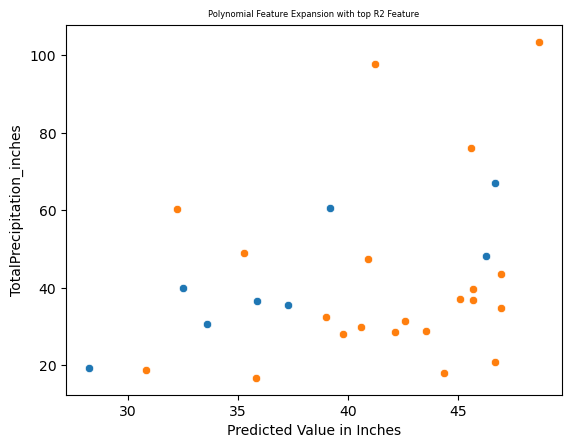

In [168]:
print(X_10[:, 0])
sns.scatterplot(x = reg2.predict(X_test), y = y_test)
sns.scatterplot(x = reg2.predict(X_train), y = y_train)
plt.title('Polynomial Feature Expansion with top R2 Feature')
plt.xlabel('Predicted Value in Inches')
plt.show()

The above chart indicates a very poor fit as well, with a min and max predicted range that is far narrower than the actual data would necessitate. Next, we bring in the additional test samples with locations outside of the rain stations.

In [183]:
X_t = df_testdata[df_testdata['year'] == 2023][predictors_weather]
y_t = df_testdata[df_testdata['year'] == 2023]['precipitation_sum']
#pf.fit(X_t)
X_t = pf.transform(X_t)
X_t = X_t[:, [r2_i_max]]
predicted = reg2.predict(X_t)
print('Predicted Values: ', predicted)
print('Actual Values: ', y_t.values)
print('RMSE: ', rmse(y_t, predicted))
print('R2: ', r2_score(y_t, predicted))
print(reg2.coef_)

Predicted Values:  [43.12057947 53.01173543 31.73679573 47.00330015 32.16954017 50.16788294]
Actual Values:  [38.077 69.002 48.504 38.872 30.992 40.821]
RMSE:  10.932628973699996
R2:  0.18988122841234856
[-55.6398422]


While the above yields results that are better than the initial, the model cannot be said to be "accurate" with an R2 of ~.2. However, it may stand to reason that further data could refine this model further, finding patterns that were not present in the few locations analyzed. 